<center><h3>Transfer Learning for Image Classification</h3></center>
<center><font size=\"4\">Name: Jiahao Liu<br>Github: Julius-JiahaoLiu</font></center>

In [21]:
!pip install keras
!pip install tensorflow
!pip install certifi

In [224]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize

#### (a) In this problem, we are trying to build a classifier that distinguishes images of six scenes.
It is highly recommended that you complete this project using Keras (https://keras.io) and Python.
#### (b) Data Exploration and Pre-processing
##### i. Images in each class are given in separate folders in the training and test sets. You can encode your classes using one-hot encoding.

##### ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

**Answer:** I will use *ImageDataGenerator* to one-hot encoding the classes label and resize the images to (224, 224), i.e. the common size for models.

In [112]:
data_generator = ImageDataGenerator(rescale = 1./255) # normalizes pixel values to be between 0 and 1.

train_generator = data_generator.flow_from_directory(
    directory = '../data/seg_train',
    target_size = (224, 224), # resizes images to the specified dimensions
    batch_size = 32,
    class_mode = 'categorical', # automatically applies one-hot encoding to the labels.
    shuffle = True
)

print(train_generator.class_indices)

Found 14034 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [113]:
test_generator = data_generator.flow_from_directory(
    directory = '../data/seg_test',
    target_size = (224, 224), # resizes images to the specified dimensions
    batch_size = 32,
    class_mode = 'categorical', # automatically applies one-hot encoding to the labels.
    shuffle = True
)

print(test_generator.class_indices)

Found 3000 images belonging to 6 classes.
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


#### (c) Transfer Learning
(https://builtin.com/data-science/transfer-learning) 

##### i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses **transfer learning**, which uses deep learning models that are trained on very large datasets such as *ImageNet* as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models *ResNet50*, *ResNet100*, *EfficientNetB0*, and *VGG16*. For those pre-trained networks, you will only train the last fully connected layer, and will **freeze all layers before them** (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

In [ ]:
num_classes = train_generator.num_classes
# create a function that accepts a base model and returns a new model with custom top layers.
def create_model_i(base_model, num_classes):
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Convert features to a single vector per image
    # x = Dense(256, activation='relu')(x)  # set number of units to 256, and use ReLU activation function
    predictions = Dense(num_classes, activation='softmax')(x)  # Final layer for classification

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [ ]:
# Load the base models
# Because I have resized images to (224, 224), and they have 3 channels (RGB), use input_shape=(224, 224, 3).
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the model
model_resnet50_i = create_model_i(base_model_resnet50, num_classes)
model_resnet101_i = create_model_i(base_model_resnet101, num_classes)
model_efficientnet_i = create_model_i(base_model_efficientnet, num_classes)
model_vgg16_i = create_model_i(base_model_vgg16, num_classes)

In [116]:

model_resnet50_i.compile(optimizer = Adam(learning_rate = 0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)

# Train the model
model_resnet50_i.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30,
    # callbacks = [early_stopping]
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 571s 1s/step - accuracy: 0.3188 - loss: 1.6506 - val_accuracy: 0.4866 - val_loss: 1.3488
Epoch 2/30
  1/438 ━━━━━━━━━━━━━━━━━━━━ 10:21 1s/step - accuracy: 0.5938 - loss: 1.3336

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


438/438 ━━━━━━━━━━━━━━━━━━━━ 105s 238ms/step - accuracy: 0.5938 - loss: 1.3336 - val_accuracy: 0.4970 - val_loss: 1.3468
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 644s 1s/step - accuracy: 0.5063 - loss: 1.3133 - val_accuracy: 0.5548 - val_loss: 1.2258
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 107s 241ms/step - accuracy: 0.6875 - loss: 1.1454 - val_accuracy: 0.5383 - val_loss: 1.2291
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.5539 - loss: 1.2009 - val_accuracy: 0.5302 - val_loss: 1.1703
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - accuracy: 0.5625 - loss: 1.1416 - val_accuracy: 0.5417 - val_loss: 1.1682
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.5763 - loss: 1.1410 - val_accuracy: 0.5470 - val_loss: 1.1373
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - accuracy: 0.3750 - loss: 1.2545 - val_accuracy: 0.5538 - val_loss: 1.1398
Epoch 9/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.5900 - loss: 1.1026 - val_accur

In [117]:
# Evaluate model_resnet50
model_resnet50_loss, model_resnet50_accuracy = model_resnet50_i.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('ResNet50 Model Test accuracy:', model_resnet50_accuracy)
print('ResNet50 Model Test loss:', model_resnet50_loss)

93/93 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.6286 - loss: 0.9378
ResNet50 Model Test accuracy: 0.6297042965888977
ResNet50 Model Test loss: 0.9406996965408325


In [118]:
model_resnet101_i.compile(optimizer = Adam(learning_rate = 0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
model_resnet101_i.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30, 
    # callbacks = [early_stopping]
)

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1022s 2s/step - accuracy: 0.3240 - loss: 1.6266 - val_accuracy: 0.4577 - val_loss: 1.3697
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 168s 379ms/step - accuracy: 0.3438 - loss: 1.4805 - val_accuracy: 0.4476 - val_loss: 1.3748
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 886s 2s/step - accuracy: 0.4837 - loss: 1.3279 - val_accuracy: 0.5265 - val_loss: 1.2427
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 156s 353ms/step - accuracy: 0.6250 - loss: 1.1162 - val_accuracy: 0.5323 - val_loss: 1.2363
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1014s 2s/step - accuracy: 0.5339 - loss: 1.2203 - val_accuracy: 0.5316 - val_loss: 1.1893
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 172s 389ms/step - accuracy: 0.6562 - loss: 1.2634 - val_accuracy: 0.5316 - val_loss: 1.1899
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 982s 2s/step - accuracy: 0.5366 - loss: 1.1751 - val_accuracy: 0.5477 - val_loss: 1.1575
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 154s 348ms/step - accuracy: 0.6250 - loss: 1.1

In [119]:
# Evaluate model_resnet101
model_resnet101_loss, model_resnet101_accuracy = model_resnet101_i.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('ResNet101 Model Test accuracy:', model_resnet101_accuracy)
print('ResNet101 Model Test loss:', model_resnet101_loss)

93/93 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6273 - loss: 0.9639
ResNet101 Model Test accuracy: 0.6236559152603149
ResNet101 Model Test loss: 0.9968494772911072


In [120]:
model_efficientnet_i.compile(optimizer = Adam(learning_rate = 0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])
model_efficientnet_i.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30, 
    # callbacks = [early_stopping]
)

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 208s 461ms/step - accuracy: 0.1724 - loss: 1.8105 - val_accuracy: 0.2019 - val_loss: 1.7746
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.2500 - loss: 1.7848 - val_accuracy: 0.2053 - val_loss: 1.7753
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 202s 462ms/step - accuracy: 0.1951 - loss: 1.7870 - val_accuracy: 0.1583 - val_loss: 1.7971
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.3125 - loss: 1.7464 - val_accuracy: 0.1569 - val_loss: 1.7989
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 194s 444ms/step - accuracy: 0.2089 - loss: 1.7749 - val_accuracy: 0.2786 - val_loss: 1.7607
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.1875 - loss: 1.7236 - val_accuracy: 0.2742 - val_loss: 1.7563
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 200s 456ms/step - accuracy: 0.2207 - loss: 1.7654 - val_accuracy: 0.2140 - val_loss: 1.7377
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.3125 - loss: 1

In [121]:
# Evaluate model_efficientnet
model_efficientnet_loss, model_efficientnet_accuracy = model_efficientnet_i.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('EfficientNetB0 Model Test accuracy:', model_efficientnet_accuracy)
print('EfficientNetB0 Model Test loss:', model_efficientnet_loss)

93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 371ms/step - accuracy: 0.2862 - loss: 1.6822
EfficientNetB0 Model Test accuracy: 0.2849462330341339
EfficientNetB0 Model Test loss: 1.6861350536346436


In [122]:
model_vgg16_i.compile(optimizer = Adam(learning_rate = 0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg16_i.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30,
    # callbacks = [early_stopping]
)

Epoch 1/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1737s 4s/step - accuracy: 0.6002 - loss: 1.2899 - val_accuracy: 0.7967 - val_loss: 0.6939
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 319s 721ms/step - accuracy: 0.7812 - loss: 0.7355 - val_accuracy: 0.7977 - val_loss: 0.6904
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1634s 4s/step - accuracy: 0.8150 - loss: 0.6347 - val_accuracy: 0.8243 - val_loss: 0.5524
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 280s 634ms/step - accuracy: 0.7500 - loss: 0.7057 - val_accuracy: 0.8243 - val_loss: 0.5530
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1719s 4s/step - accuracy: 0.8378 - loss: 0.5195 - val_accuracy: 0.8377 - val_loss: 0.4900
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 295s 668ms/step - accuracy: 0.7500 - loss: 0.6624 - val_accuracy: 0.8367 - val_loss: 0.4893
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 1727s 4s/step - accuracy: 0.8467 - loss: 0.4658 - val_accuracy: 0.8421 - val_loss: 0.4581
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 298s 674ms/step - accuracy: 0.8438 - loss: 0

In [123]:
# Evaluate model_vgg16
model_vgg16_loss, model_vgg16_accuracy = model_vgg16_i.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('VGG16 Model Test accuracy:', model_vgg16_accuracy)
print('VGG16 Model Test loss:', model_vgg16_loss)

93/93 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.8715 - loss: 0.3658
VGG16 Model Test accuracy: 0.8726478219032288
VGG16 Model Test loss: 0.3609078824520111


##### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

##### iii. Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization (https://en.wikipedia.org/wiki/Batch_normalization), and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [157]:
# Data generator with data augmentation for training data
train_data_generator = ImageDataGenerator(
    # rescale = 1./255,
    rotation_range = 20,            # Random rotation between -20 and +20 degrees
    zoom_range = 0.2,               # Random zoom between 80% and 120%
    width_shift_range = 0.2,        # Randomly translate images horizontally
    height_shift_range = 0.2,       # Randomly translate images vertically
    horizontal_flip = True,         # Random horizontal flips
    vertical_flip = True,           # Random vertical flips
    preprocessing_function = preprocess_input
)

# Data generator for test data (without augmentation)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data_generator.flow_from_directory(
    directory = '../data/seg_train',
    target_size = (256, 256),  # Resize to a larger size for cropping
    batch_size = 5, # Batch size of 5 as specified in the question
    class_mode = 'categorical',
    shuffle = True
)

test_generator = test_data_generator.flow_from_directory(
    directory = '../data/seg_test',
    target_size = (256, 256),
    batch_size = 5,  # Batch size of 5 as specified in the question
    class_mode = 'categorical',
    shuffle = False  # Typically, we don't shuffle test data
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [158]:
def create_model_iii(base_model, num_classes):
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Data Augmentation layers
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomCrop(224, 224),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomFlip('horizontal')
    ])

    # Input layer for training and testing datasets
    inputs = tf.keras.Input(shape=(256, 256, 3))
    # Apply data augmentation
    x = data_augmentation(inputs)

    # Preprocess input for ResNet50
    x = preprocess_input(x)

    # Add custom layers on top
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)  # Convert features to a single vector per image

    # Add a Dense layer with ReLU activation and L2 regularization
    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-2))(x)

    # Add Batch Normalization
    x = BatchNormalization()(x)

    # Add Dropout
    x = Dropout(0.2)(x) # Dropout rate of 20%

    # Final Dense layer with softmax activation for classification
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the complete model
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    return model


##### iii a. ResNet50 Model

In [159]:
num_classes = train_generator.num_classes

base_model_resnet50_iii = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet50_iii = create_model_iii(base_model_resnet50_iii, num_classes)

model_resnet50_iii.compile(
    optimizer = Adam(learning_rate = 0.001),  # Adam optimizer
    loss = 'categorical_crossentropy',      # Multinomial cross-entropy loss
    metrics = ['accuracy']
)

In [160]:
# Train the model
model_resnet50_iii.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30, 
)

Epoch 1/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 642s 226ms/step - accuracy: 0.6397 - loss: 4.7404 - val_accuracy: 0.7483 - val_loss: 1.4140
Epoch 2/30
   1/2806 ━━━━━━━━━━━━━━━━━━━━ 10:28 224ms/step - accuracy: 0.6000 - loss: 1.5164

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2806/2806 ━━━━━━━━━━━━━━━━━━━━ 102s 36ms/step - accuracy: 0.6000 - loss: 1.5164 - val_accuracy: 0.7547 - val_loss: 1.4009
Epoch 3/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 647s 231ms/step - accuracy: 0.6937 - loss: 1.4968 - val_accuracy: 0.7713 - val_loss: 1.1534
Epoch 4/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 105s 37ms/step - accuracy: 0.8000 - loss: 1.1906 - val_accuracy: 0.7673 - val_loss: 1.1602
Epoch 5/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 620s 221ms/step - accuracy: 0.6960 - loss: 1.3383 - val_accuracy: 0.7610 - val_loss: 1.0605
Epoch 6/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 98s 35ms/step - accuracy: 1.0000 - loss: 0.6470 - val_accuracy: 0.7643 - val_loss: 1.0565
Epoch 7/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 601s 214ms/step - accuracy: 0.7006 - loss: 1.2578 - val_accuracy: 0.7897 - val_loss: 0.9460
Epoch 8/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 106s 38ms/step - accuracy: 0.6000 - loss: 2.6832 - val_accuracy: 0.7850 - val_loss: 0.9488
Epoch 9/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 624s 222ms/step - accuracy: 0.7097 -

In [161]:
# Evaluate ResNet50 model with custom top layers
model_resnet50_iii_loss, model_resnet50_iii_accuracy = model_resnet50_iii.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('Test accuracy for ResNet50 Model after Image Augmentation and Regulization:', model_resnet50_iii_accuracy)
print('Test loss for ResNet50 Model after Image Augmentation and Regulization:', model_resnet50_iii_loss)

600/600 ━━━━━━━━━━━━━━━━━━━━ 107s 177ms/step - accuracy: 0.7415 - loss: 0.9394
Test accuracy for ResNet50 Model after Image Augmentation and Regulization: 0.7913333177566528
Test loss for ResNet50 Model after Image Augmentation and Regulization: 0.8232404589653015


##### iii b. ResNet101 Model

In [162]:
base_model_resnet101_iii = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet101_iii = create_model_iii(base_model_resnet101_iii, num_classes)

model_resnet101_iii.compile(
    optimizer = Adam(learning_rate = 0.001),  
    loss = 'categorical_crossentropy',      # Multinomial cross-entropy loss
    metrics = ['accuracy']
)

In [163]:
# Train the model
model_resnet101_iii.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30,
)

Epoch 1/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1069s 378ms/step - accuracy: 0.6470 - loss: 4.8156 - val_accuracy: 0.7610 - val_loss: 1.3804
Epoch 2/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 177s 63ms/step - accuracy: 0.8000 - loss: 1.2518 - val_accuracy: 0.7647 - val_loss: 1.3739
Epoch 3/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1121s 400ms/step - accuracy: 0.6920 - loss: 1.5002 - val_accuracy: 0.7927 - val_loss: 1.1083
Epoch 4/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 177s 63ms/step - accuracy: 0.6000 - loss: 1.1583 - val_accuracy: 0.7920 - val_loss: 1.1097
Epoch 5/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1134s 404ms/step - accuracy: 0.7269 - loss: 1.2552 - val_accuracy: 0.8263 - val_loss: 0.9053
Epoch 6/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 206s 73ms/step - accuracy: 0.4000 - loss: 2.0818 - val_accuracy: 0.8277 - val_loss: 0.9061
Epoch 7/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1200s 428ms/step - accuracy: 0.7196 - loss: 1.1965 - val_accuracy: 0.7923 - val_loss: 0.9423
Epoch 8/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 219s 78ms/step - ac

In [164]:
# Evaluate resnet101_iii
model_resnet101_iii_loss, model_resnet101_iii_accuracy = model_resnet101_iii.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('Test accuracy for ResNet101 Model after Image Augmentation and Regulization:', model_resnet101_iii_accuracy)
print('Test loss for ResNet101 Model after Image Augmentation and Regulization:', model_resnet101_iii_loss)

600/600 ━━━━━━━━━━━━━━━━━━━━ 201s 335ms/step - accuracy: 0.8339 - loss: 0.7423
Test accuracy for ResNet101 Model after Image Augmentation and Regulization: 0.7749999761581421
Test loss for ResNet101 Model after Image Augmentation and Regulization: 0.9007177948951721


##### iii c. EfficientNetB0 Model

In [165]:
base_model_efficient_iii = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_efficient_iii = create_model_iii(base_model_efficient_iii, num_classes)

model_efficient_iii.compile(
    optimizer = Adam(learning_rate = 0.001),  
    loss = 'categorical_crossentropy',      # Multinomial cross-entropy loss
    metrics = ['accuracy']
)

In [166]:
# Train the model
model_efficient_iii.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30,
)

Epoch 1/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 315s 109ms/step - accuracy: 0.3119 - loss: 5.9143 - val_accuracy: 0.4110 - val_loss: 2.3616
Epoch 2/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - accuracy: 0.2000 - loss: 2.6030 - val_accuracy: 0.4143 - val_loss: 2.3511
Epoch 3/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 286s 102ms/step - accuracy: 0.3464 - loss: 2.2645 - val_accuracy: 0.2750 - val_loss: 2.3670
Epoch 4/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.4000 - loss: 2.2453 - val_accuracy: 0.2803 - val_loss: 2.3303
Epoch 5/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 272s 97ms/step - accuracy: 0.3546 - loss: 2.0009 - val_accuracy: 0.4233 - val_loss: 1.7468
Epoch 6/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.2000 - loss: 2.2207 - val_accuracy: 0.4250 - val_loss: 1.7455
Epoch 7/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 308s 110ms/step - accuracy: 0.3598 - loss: 1.8671 - val_accuracy: 0.2870 - val_loss: 1.8781
Epoch 8/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0

In [167]:
# Evaluate model_efficient_iii
model_efficient_iii_loss, model_efficient_iii_accuracy = model_efficient_iii.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('Test accuracy for EfficientNetB0 Model after Image Augmentation and Regulization:', model_efficient_iii_accuracy)
print('Test loss for EfficientNetB0 Model after Image Augmentation and Regulization:', model_efficient_iii_loss)

600/600 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.3337 - loss: 1.6587
Test accuracy for EfficientNetB0 Model after Image Augmentation and Regulization: 0.2983333468437195
Test loss for EfficientNetB0 Model after Image Augmentation and Regulization: 1.8006759881973267


##### iii d. VGG16 Model

(I tried the Adam with learning rate 0.001, which leads to around 60 mins for one epoch, so I change to a higher learning rate.)

**Answer:** Based on the observation of following val_accuracy and val_loss during fitting process of 30 epochs for VGG16 model, I found that **the validation accuracy peaking at epoch 5 and then decreasing**, suggesting that the model begins to **overfit to the training data** after the initial epochs. That's why the test accuracy is only 0.5527 for 30 epochs, worse than the 0.8726 for 30 epochs VGG16 without Image Argumentation and L2 Regulization.

In [170]:
base_model_VGG16_iii = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_VGG16_iii = create_model_iii(base_model_VGG16_iii, num_classes)

model_VGG16_iii.compile(
    optimizer = Adam(learning_rate = 0.01), # use a higher learning rate for VGG16 for faster convergence  
    loss = 'categorical_crossentropy',      # Multinomial cross-entropy loss
    metrics = ['accuracy']
)

In [171]:
# Train the model
model_VGG16_iii.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 30,
)

Epoch 1/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 5845s 2s/step - accuracy: 0.5444 - loss: 5.1468 - val_accuracy: 0.5840 - val_loss: 3.3320
Epoch 2/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 711s 253ms/step - accuracy: 0.2000 - loss: 2.9536 - val_accuracy: 0.6053 - val_loss: 3.0221
Epoch 3/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 15459s 6s/step - accuracy: 0.5727 - loss: 2.6388 - val_accuracy: 0.6200 - val_loss: 2.6219
Epoch 4/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1210s 431ms/step - accuracy: 0.4000 - loss: 2.6995 - val_accuracy: 0.6160 - val_loss: 2.6171
Epoch 5/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 7849s 3s/step - accuracy: 0.5723 - loss: 2.4935 - val_accuracy: 0.7550 - val_loss: 2.0966
Epoch 6/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1408s 502ms/step - accuracy: 0.6000 - loss: 2.3722 - val_accuracy: 0.7277 - val_loss: 2.2662
Epoch 7/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 1743s 621ms/step - accuracy: 0.5752 - loss: 2.3878 - val_accuracy: 0.6123 - val_loss: 2.4867
Epoch 8/30
2806/2806 ━━━━━━━━━━━━━━━━━━━━ 373s 133ms/step - accu

In [172]:
# Evaluate VGG16_iii
model_VGG16_iii_loss, model_VGG16_iii_accuracy = model_VGG16_iii.evaluate(
    test_generator,
    steps = test_generator.samples // test_generator.batch_size
)
print('Test accuracy for VGG16 Model with 30 epochs after Image Augmentation and Regulization:', model_VGG16_iii_accuracy)
print('Test loss for VGG16 Model with 30 epochs after Image Augmentation and Regulization:', model_VGG16_iii_loss)

600/600 ━━━━━━━━━━━━━━━━━━━━ 318s 530ms/step - accuracy: 0.4515 - loss: 3.3218
Test accuracy for VGG16 Model after Image Augmentation and Regulization: 0.5526666641235352
Test loss for VGG16 Model after Image Augmentation and Regulization: 3.0614097118377686


##### iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.


**Answer: I choose to fit models with epochs 70 with early stopping on validation loss and stop training if it doesn't improve after 10 epochs.**

In [173]:
data_generator_with_validation = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Include validation split
train_generator = data_generator_with_validation.flow_from_directory(
    directory = '../data/seg_train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',  # Set as training data
    shuffle = True
)

validation_generator = data_generator_with_validation.flow_from_directory(
    directory = '../data/seg_train',  # Use the same directory as training data
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',  # Set as validation data
    shuffle = True
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory = '../data/seg_test',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False  # Typically, no need to shuffle test data
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [174]:
def create_model_iv(base_model, num_classes):
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

##### iv. a ResNet50 with epochs = 70, ADAM learning rate 0.01 and Early Stop Callbacks if validation loss doesn't improve after 10 epochs.

In [175]:
num_classes = train_generator.num_classes
# For ResNet50
base_model_resnet50_iv = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet50_iv = create_model_iv(base_model_resnet50_iv, num_classes)
model_resnet50_iv.compile(optimizer = Adam(learning_rate = 0.01), # Use a higher learning rate to speed up training
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [176]:
epochs = 70  # I think 70 epochs is a good enough for early stopping to work
callbacks = [
    # Monitor the validation loss and stop training if it doesn't improve after 10 epochs
    # After stopping, the model weights will be rolled back to the epoch with the best validation loss.
    EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True),
    # # The ModelCheckpoint callback saves the model parameters that have the lowest validation loss
    # ModelCheckpoint('best_resnet50_model.keras', monitor='val_loss', save_best_only = True)
]
# Train ResNet50 Model
history_resnet50 = model_resnet50_iv.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.3759 - loss: 1.5543 - val_accuracy: 0.5790 - val_loss: 1.0803
Epoch 2/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 89s 253ms/step - accuracy: 0.5938 - loss: 1.0735 - val_accuracy: 0.5575 - val_loss: 1.1006
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.5585 - loss: 1.1278 - val_accuracy: 0.6078 - val_loss: 1.0017
Epoch 4/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.4688 - loss: 1.0938 - val_accuracy: 0.5884 - val_loss: 1.0121
Epoch 5/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.5817 - loss: 1.0518 - val_accuracy: 0.6203 - val_loss: 0.9706
Epoch 6/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 232ms/step - accuracy: 0.6562 - loss: 0.8416 - val_accuracy: 0.6261 - val_loss: 0.9720
Epoch 7/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.6223 - loss: 0.9911 - val_accuracy: 0.5952 - val_loss: 1.0637
Epoch 8/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.5625 - loss: 1.1755 - 

**ResNet50 Model Stopped at epoch 63/70**: after epoch 53 with val_loss 0.7657, the val_loss did not improve for 10 consecutive epochs (from epoch 54 to 63), triggering early stopping.

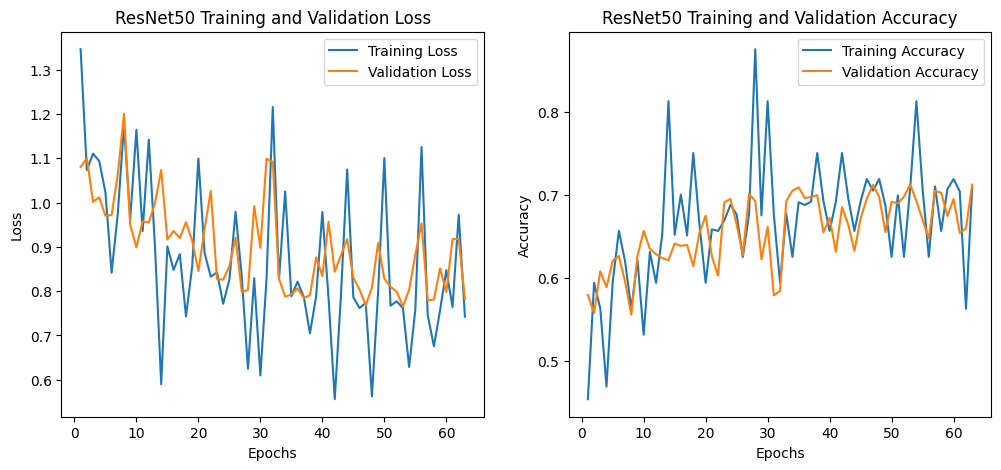

In [177]:
# Define the range of epochs for plotting starting from 1
epochs_range = range(1, len(history_resnet50.history['loss']) + 1)
# For ResNet50
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history_resnet50.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history_resnet50.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_resnet50.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### iv b. Train ResNet101 with epochs = 70, ADAM learning rate 0.01 and Early Stop Callbacks if validation loss doesn't improve after 10 epochs.

In [178]:
# For ResNet101
base_model_resnet101_iv = ResNet101(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
model_resnet101_iv = create_model_iv(base_model_resnet101_iv, num_classes)
model_resnet101_iv.compile(optimizer = Adam(learning_rate = 0.01), # Use a higher learning rate to speed up training
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [179]:
callbacks = [
    # Monitor the validation loss and stop training if it doesn't improve after 10 epochs
    # After stopping, the model weights will be rolled back to the epoch with the best validation loss.
    EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True),
    # # The ModelCheckpoint callback saves the model parameters that have the lowest validation loss
    # ModelCheckpoint('best_resnet101_model.keras', monitor = 'val_loss', save_best_only = True)
]
# Train ResNet101 Model
history_resnet101 = model_resnet101_iv.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - accuracy: 0.3781 - loss: 1.5374 - val_accuracy: 0.5226 - val_loss: 1.1788
Epoch 2/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 138s 391ms/step - accuracy: 0.5312 - loss: 1.1026 - val_accuracy: 0.5000 - val_loss: 1.1938
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 711s 2s/step - accuracy: 0.5439 - loss: 1.1326 - val_accuracy: 0.5453 - val_loss: 1.0921
Epoch 4/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 140s 396ms/step - accuracy: 0.5938 - loss: 0.9719 - val_accuracy: 0.5341 - val_loss: 1.1142
Epoch 5/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.5735 - loss: 1.0776 - val_accuracy: 0.5848 - val_loss: 1.0401
Epoch 6/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 393ms/step - accuracy: 0.5938 - loss: 0.9798 - val_accuracy: 0.5833 - val_loss: 1.0345
Epoch 7/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 709s 2s/step - accuracy: 0.5901 - loss: 1.0184 - val_accuracy: 0.5740 - val_loss: 1.0353
Epoch 8/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 393ms/step - accuracy: 0.7500 - loss: 0.856

**ResNet101 Model Stopped at epoch 33/70:** This implies that after epoch 23 with val_loss 0.8798, the val_loss did not improve for 10 consecutive epochs (from epoch 24 to 33), triggering early stopping.

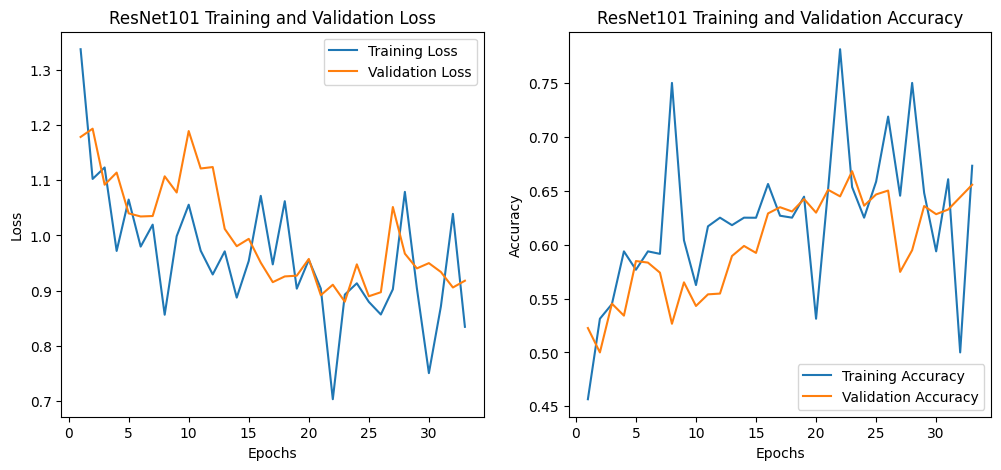

In [180]:
# Define the range of epochs for plotting starting from 1
epochs_range = range(1, len(history_resnet101.history['loss']) + 1)
# For ResNet101
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history_resnet101.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_resnet101.history['val_loss'], label='Validation Loss')
plt.title('ResNet101 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history_resnet101.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_resnet101.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet101 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### iv c. Train EfficientB0 with epochs = 70, ADAM learning rate 0.001 and Early Stop Callbacks if validation loss doesn't improve after 15 epochs. (Here I use a slower learning rate and larger vol_loss tolerancy than the other three models)

In [199]:
# For EfficientNetB0
base_model_efficient_iv = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
model_efficient_iv = create_model_iv(base_model_efficient_iv, num_classes)
model_efficient_iv.compile(optimizer = Adam(learning_rate = 0.001), 
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy'])

In [200]:
callbacks = [
    # Monitor the validation loss and stop training if it doesn't improve after 15 epochs
    # After stopping, the model weights will be rolled back to the epoch with the best validation loss.
    EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True),
    # # The ModelCheckpoint callback saves the model parameters that have the lowest validation loss
    # ModelCheckpoint('best_efficientNetB0_model.keras', monitor = 'val_loss', save_best_only = True)
]
# Train EfficientNetB0 Model
history_efficient = model_efficient_iv.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 204s 552ms/step - accuracy: 0.1740 - loss: 1.8112 - val_accuracy: 0.1932 - val_loss: 1.7786
Epoch 2/70
  1/350 ━━━━━━━━━━━━━━━━━━━━ 2:50 489ms/step - accuracy: 0.2500 - loss: 1.7667

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.2500 - loss: 1.7667 - val_accuracy: 0.1699 - val_loss: 1.7805
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 191s 546ms/step - accuracy: 0.1993 - loss: 1.7873 - val_accuracy: 0.1861 - val_loss: 1.7846
Epoch 4/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 44s 126ms/step - accuracy: 0.1875 - loss: 1.8290 - val_accuracy: 0.2162 - val_loss: 1.7788
Epoch 5/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 194s 553ms/step - accuracy: 0.2016 - loss: 1.7834 - val_accuracy: 0.2022 - val_loss: 1.7628
Epoch 6/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.2500 - loss: 1.7944 - val_accuracy: 0.1968 - val_loss: 1.7594
Epoch 7/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 197s 564ms/step - accuracy: 0.2144 - loss: 1.7638 - val_accuracy: 0.1907 - val_loss: 1.7589
Epoch 8/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 109ms/step - accuracy: 0.2500 - loss: 1.7741 - val_accuracy: 0.1976 - val_loss: 1.7591
Epoch 9/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 225s 643ms/step - accuracy: 0.2212 - loss: 1.7649 - 

**EfficientNetB0 Model Stopped at epoch 70/70**: the minimum observed val_loss 1.6640 is at epoch 64. 

Based on the overall decrease trend in the following Loss vs. Epoch graph, we can forsee that there might still be slight improvement of validation loss with higher epoch.

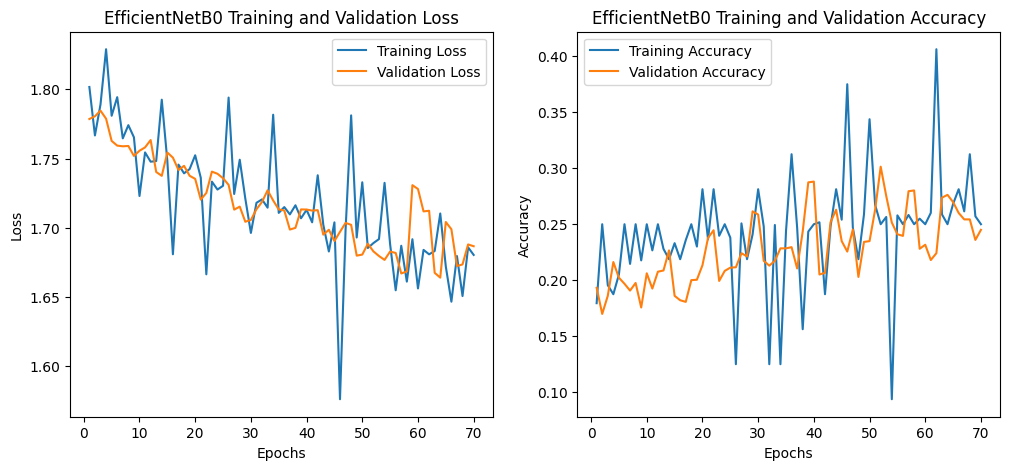

In [201]:
# Define the range of epochs for plotting starting from 1
epochs_range = range(1, len(history_efficient.history['loss']) + 1)
# For EfficientNetB0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history_efficient.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_efficient.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history_efficient.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_efficient.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### iv d. Train VGG16 with epochs = 70, ADAM learning rate 0.01 and Early Stop Callbacks if validation loss doesn't improve after 15 epochs.

In [219]:
# For VGG16
base_model_vgg16_iv = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
model_vgg16_iv = create_model_iv(base_model_vgg16_iv, num_classes)
model_vgg16_iv.compile(optimizer = Adam(learning_rate = 0.01), # Use a higher learning rate to speed up training
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

In [220]:
callbacks = [
    # Monitor the validation loss and stop training if it doesn't improve after 15 epochs
    # After stopping, the model weights will be rolled back to the epoch with the best validation loss.
    EarlyStopping(monitor = 'val_loss', patience = 15, restore_best_weights = True),
    # # The ModelCheckpoint callback saves the model parameters that have the lowest validation loss
    # ModelCheckpoint('best_vgg16_model.keras', monitor='val_loss', save_best_only = True)
]
# Train VGG16 Model
history_vgg16 = model_vgg16_iv.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    epochs = epochs,
    callbacks = callbacks
)

Epoch 1/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 1359s 4s/step - accuracy: 0.7174 - loss: 0.7732 - val_accuracy: 0.8283 - val_loss: 0.4461
Epoch 2/70
  1/350 ━━━━━━━━━━━━━━━━━━━━ 18:02 3s/step - accuracy: 0.7812 - loss: 0.4377

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


350/350 ━━━━━━━━━━━━━━━━━━━━ 255s 721ms/step - accuracy: 0.7812 - loss: 0.4377 - val_accuracy: 0.8380 - val_loss: 0.4300
Epoch 3/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 1299s 4s/step - accuracy: 0.8520 - loss: 0.4013 - val_accuracy: 0.8707 - val_loss: 0.3614
Epoch 4/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 255s 722ms/step - accuracy: 0.9375 - loss: 0.3189 - val_accuracy: 0.8700 - val_loss: 0.3635
Epoch 5/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 1308s 4s/step - accuracy: 0.8777 - loss: 0.3456 - val_accuracy: 0.8606 - val_loss: 0.3726
Epoch 6/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 264s 747ms/step - accuracy: 0.8750 - loss: 0.3106 - val_accuracy: 0.8639 - val_loss: 0.3703
Epoch 7/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 1338s 4s/step - accuracy: 0.8772 - loss: 0.3381 - val_accuracy: 0.8779 - val_loss: 0.3458
Epoch 8/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 263s 744ms/step - accuracy: 0.9062 - loss: 0.2577 - val_accuracy: 0.8786 - val_loss: 0.3475
Epoch 9/70
350/350 ━━━━━━━━━━━━━━━━━━━━ 1335s 4s/step - accuracy: 0.8933 - loss: 0.3100 - val

**VGG16 Model Stopped at epoch 35/70**: after epoch 20 with val_loss 0.3191, the val_loss did not improve for 15 consecutive epochs (from epoch 21 to 35), triggering early stopping.

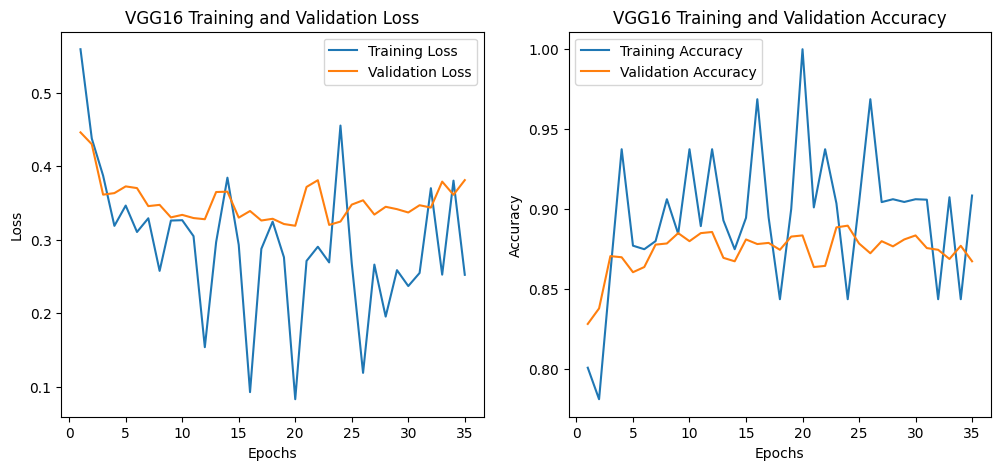

In [221]:
# Define the range of epochs, starting from 1
epochs_range = range(1, len(history_vgg16.history['loss']) + 1)
# For VGG16
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history_vgg16.history['loss'], label='Training Loss')
plt.plot(epochs_range, history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### v. Report training, validation, and test **Precision, Recall, AUC, and F1 score** for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

**Answer:** Based on the Test Precision: 0.9089, Recall: 0.9091, F1 Score: 0.9085, we can conclude that VGG16 obviously outperform ResNet50 and ResNet101 with score around 0.70, and two ResNet Models outperform EfficientNetB0 with score around 0.25.

In [187]:
# Generators for evaluation (without shuffling)
train_generator_eval = data_generator_with_validation.flow_from_directory(
    directory='../data/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False  # Important: shuffle=False for evaluation
)

validation_generator_eval = data_generator_with_validation.flow_from_directory(
    directory='../data/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important: shuffle=False for evaluation
)

test_generator_eval = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory='../data/seg_test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: shuffle=False for evaluation
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [188]:
# True labels
train_labels = train_generator_eval.classes
val_labels = validation_generator_eval.classes
test_labels = test_generator_eval.classes

# Class indices (mapping from class names to class indices)
class_labels = list(train_generator_eval.class_indices.keys())

# Number of classes
n_classes = train_generator_eval.num_classes

In [190]:
# For ResNet50 Model
# Predictions for training data
train_preds_resnet50 = model_resnet50_iv.predict(train_generator_eval, verbose=1)
train_pred_classes_resnet50 = np.argmax(train_preds_resnet50, axis=1)

# Predictions for validation data
val_preds_resnet50 = model_resnet50_iv.predict(validation_generator_eval, verbose=1)
val_pred_classes_resnet50 = np.argmax(val_preds_resnet50, axis=1)

# Predictions for test data
test_preds_resnet50 = model_resnet50_iv.predict(test_generator_eval, verbose=1)
test_pred_classes_resnet50 = np.argmax(test_preds_resnet50, axis=1)

351/351 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step


In [191]:
# Repeat the above steps for ResNet101 Model
train_preds_resnet101 = model_resnet101_iv.predict(train_generator_eval, verbose=1)
train_pred_classes_resnet101 = np.argmax(train_preds_resnet101, axis=1)

val_preds_resnet101 = model_resnet101_iv.predict(validation_generator_eval, verbose=1)
val_pred_classes_resnet101 = np.argmax(val_preds_resnet101, axis=1)

test_preds_resnet101 = model_resnet101_iv.predict(test_generator_eval, verbose=1)
test_pred_classes_resnet101 = np.argmax(test_preds_resnet101, axis=1)

351/351 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step


In [202]:
# Repeat the above steps for EfficientNetB0 Model
train_preds_efficient = model_efficient_iv.predict(train_generator_eval, verbose=1)
train_pred_classes_efficient = np.argmax(train_preds_efficient, axis=1)

val_preds_efficient = model_efficient_iv.predict(validation_generator_eval, verbose=1)
val_pred_classes_efficient = np.argmax(val_preds_efficient, axis=1)

test_preds_efficient = model_efficient_iv.predict(test_generator_eval, verbose=1)
test_pred_classes_efficient = np.argmax(test_preds_efficient, axis=1)

351/351 ━━━━━━━━━━━━━━━━━━━━ 171s 479ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 484ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 44s 469ms/step


In [222]:
# For VGG16 Model
# Predictions for training data
train_preds_vgg16 = model_vgg16_iv.predict(train_generator_eval, verbose=1)
train_pred_classes_vgg16 = np.argmax(train_preds_vgg16, axis=1)

# Predictions for validation data
val_preds_vgg16 = model_vgg16_iv.predict(validation_generator_eval, verbose=1)
val_pred_classes_vgg16 = np.argmax(val_preds_vgg16, axis=1)

# Predictions for test data
test_preds_vgg16 = model_vgg16_iv.predict(test_generator_eval, verbose=1)
test_pred_classes_vgg16 = np.argmax(test_preds_vgg16, axis=1)

351/351 ━━━━━━━━━━━━━━━━━━━━ 1221s 3s/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step


Compute and Print the Metrics for different models:

In [214]:
def check_predicted_classed_distribution(model_name, train_pred_classes, val_pred_classes, test_pred_classes):
    print(f"\n{model_name} Model Predicted Classes Distribution:")
    print("Class indices:", train_generator.class_indices)
    # For training data
    unique_classes_train, counts_train = np.unique(train_pred_classes, return_counts=True)
    print("\nTraining Predicted Class Distribution:")
    for cls, count in zip(unique_classes_train, counts_train):
        print(f"Class {cls}: {count} samples")

    # For validation data
    unique_classes_val, counts_val = np.unique(val_pred_classes, return_counts=True)
    print("\nValidation Predicted Class Distribution:")
    for cls, count in zip(unique_classes_val, counts_val):
        print(f"Class {cls}: {count} samples")

    # For test data
    unique_classes_test, counts_test = np.unique(test_pred_classes, return_counts=True)
    print("\nTest Predicted Class Distribution:")
    for cls, count in zip(unique_classes_test, counts_test):
        print(f"Class {cls}: {count} samples")


def compute_metrics(true_labels, pred_probs, pred_classes, class_labels, n_classes):
    # Specify the labels parameter
    labels = range(n_classes)
    
    # Setting zero_division=0 to specify that when there is a zero division, the metric should be set to 0 instead of raising a warning. 
    # Also, including the labels parameter ensures all classes are considered.

    # Precision, Recall, F1 Score
    precision, recall, f1_score, support = precision_recall_fscore_support(true_labels, pred_classes, average='macro', labels=labels, zero_division=0)
    
    # Classification Report
    report = classification_report(true_labels, pred_classes, target_names=class_labels, labels=labels, zero_division=0)
    
    # Binarize the labels for AUC calculation
    true_labels_binarized = label_binarize(true_labels, classes=labels)
    
    # AUC Score
    try:
        auc = roc_auc_score(true_labels_binarized, pred_probs, average='macro', multi_class='ovr')
    except ValueError:
        auc = float('nan')  # Handle cases where AUC can't be computed
    
    return precision, recall, f1_score, auc, report

def print_metrics(model_name, train_metrics, val_metrics, test_metrics):
    print(f"\n{model_name} Model Performance:")
    print("Training Metrics:")
    print(f"Precision: {train_metrics[0]:.4f}, Recall: {train_metrics[1]:.4f}, F1 Score: {train_metrics[2]:.4f}, AUC: {train_metrics[3]:.4f}\n")
    print(train_metrics[4])
    
    print("Validation Metrics:")
    print(f"Precision: {val_metrics[0]:.4f}, Recall: {val_metrics[1]:.4f}, F1 Score: {val_metrics[2]:.4f}, AUC: {val_metrics[3]:.4f}\n")
    print(val_metrics[4])
    
    print("Test Metrics:")
    print(f"Precision: {test_metrics[0]:.4f}, Recall: {test_metrics[1]:.4f}, F1 Score: {test_metrics[2]:.4f}, AUC: {test_metrics[3]:.4f}\n")
    print(test_metrics[4])

In [215]:
# Check predicted classes distribution
check_predicted_classed_distribution("ResNet50", train_pred_classes_resnet50, val_pred_classes_resnet50, test_pred_classes_resnet50)
# ResNet50 Model Metrics
train_metrics_resnet50 = compute_metrics(train_labels, train_preds_resnet50, train_pred_classes_resnet50, class_labels, n_classes)
val_metrics_resnet50 = compute_metrics(val_labels, val_preds_resnet50, val_pred_classes_resnet50, class_labels, n_classes)
test_metrics_resnet50 = compute_metrics(test_labels, test_preds_resnet50, test_pred_classes_resnet50, class_labels, n_classes)
# Print metrics for ResNet50 Model
print_metrics("ResNet50", train_metrics_resnet50, val_metrics_resnet50, test_metrics_resnet50)


ResNet50 Model Predicted Classes Distribution:
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Training Predicted Class Distribution:
Class 0: 1267 samples
Class 1: 1727 samples
Class 2: 2103 samples
Class 3: 2098 samples
Class 4: 1810 samples
Class 5: 2225 samples

Validation Predicted Class Distribution:
Class 0: 301 samples
Class 1: 429 samples
Class 2: 524 samples
Class 3: 531 samples
Class 4: 473 samples
Class 5: 546 samples

Test Predicted Class Distribution:
Class 0: 309 samples
Class 1: 451 samples
Class 2: 588 samples
Class 3: 570 samples
Class 4: 511 samples
Class 5: 571 samples

ResNet50 Model Performance:
Training Metrics:
Precision: 0.7567, Recall: 0.7437, F1 Score: 0.7458, AUC: 0.9512

              precision    recall  f1-score   support

   buildings       0.87      0.63      0.73      1753
      forest       0.92      0.88      0.90      1817
     glacier       0.65      0.71      0.68      1924
    mountain       0.65

In [216]:
# Check predicted classes distribution
check_predicted_classed_distribution("ResNet101", train_pred_classes_resnet101, val_pred_classes_resnet101, test_pred_classes_resnet101)
# ResNet101 Model Metrics
train_metrics_resnet101 = compute_metrics(train_labels, train_preds_resnet101, train_pred_classes_resnet101, class_labels, n_classes)
val_metrics_resnet101 = compute_metrics(val_labels, val_preds_resnet101, val_pred_classes_resnet101, class_labels, n_classes)
test_metrics_resnet101 = compute_metrics(test_labels, test_preds_resnet101, test_pred_classes_resnet101, class_labels, n_classes)
# Print metrics for ResNet101
print_metrics("ResNet101", train_metrics_resnet101, val_metrics_resnet101, test_metrics_resnet101)


ResNet101 Model Predicted Classes Distribution:
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Training Predicted Class Distribution:
Class 0: 2032 samples
Class 1: 1979 samples
Class 2: 1619 samples
Class 3: 2092 samples
Class 4: 1881 samples
Class 5: 1627 samples

Validation Predicted Class Distribution:
Class 0: 502 samples
Class 1: 487 samples
Class 2: 409 samples
Class 3: 518 samples
Class 4: 486 samples
Class 5: 402 samples

Test Predicted Class Distribution:
Class 0: 524 samples
Class 1: 493 samples
Class 2: 489 samples
Class 3: 570 samples
Class 4: 496 samples
Class 5: 428 samples

ResNet101 Model Performance:
Training Metrics:
Precision: 0.7037, Recall: 0.7044, F1 Score: 0.7015, AUC: 0.9332

              precision    recall  f1-score   support

   buildings       0.67      0.77      0.72      1753
      forest       0.81      0.89      0.85      1817
     glacier       0.66      0.55      0.60      1924
    mountain       0.

In [217]:
# Check predicted classes distribution
check_predicted_classed_distribution("EfficientNetB0", train_pred_classes_efficient, val_pred_classes_efficient, test_pred_classes_efficient)
# EfficientNetB0 Model Metrics
train_metrics_efficient = compute_metrics(train_labels, train_preds_efficient, train_pred_classes_efficient, class_labels, n_classes)
val_metrics_efficient = compute_metrics(val_labels, val_preds_efficient, val_pred_classes_efficient, class_labels, n_classes)
test_metrics_efficient = compute_metrics(test_labels, test_preds_efficient, test_pred_classes_efficient, class_labels, n_classes)
# Print metrics for VGG16
print_metrics("EfficientNetB0", train_metrics_efficient, val_metrics_efficient, test_metrics_efficient)



EfficientNetB0 Model Predicted Classes Distribution:
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Training Predicted Class Distribution:
Class 0: 3815 samples
Class 1: 105 samples
Class 2: 3219 samples
Class 3: 4091 samples

Validation Predicted Class Distribution:
Class 0: 920 samples
Class 1: 21 samples
Class 2: 786 samples
Class 3: 1077 samples

Test Predicted Class Distribution:
Class 0: 980 samples
Class 1: 35 samples
Class 2: 865 samples
Class 3: 1120 samples

EfficientNetB0 Model Performance:
Training Metrics:
Precision: 0.2287, Recall: 0.2812, F1 Score: 0.1949, AUC: 0.7404

              precision    recall  f1-score   support

   buildings       0.25      0.55      0.34      1753
      forest       0.53      0.03      0.06      1817
     glacier       0.24      0.40      0.30      1924
    mountain       0.35      0.71      0.47      2010
         sea       0.00      0.00      0.00      1820
      street       0.00      0.0

In [223]:
# Check predicted classes distribution
check_predicted_classed_distribution("VGG16", train_pred_classes_vgg16, val_pred_classes_vgg16, test_pred_classes_vgg16)
# VGG16 Model Metrics
train_metrics_vgg16 = compute_metrics(train_labels, train_preds_vgg16, train_pred_classes_vgg16, class_labels, n_classes)
val_metrics_vgg16 = compute_metrics(val_labels, val_preds_vgg16, val_pred_classes_vgg16, class_labels, n_classes)
test_metrics_vgg16 = compute_metrics(test_labels, test_preds_vgg16, test_pred_classes_vgg16, class_labels, n_classes)
# Print metrics for VGG16
print_metrics("VGG16", train_metrics_vgg16, val_metrics_vgg16, test_metrics_vgg16)


VGG16 Model Predicted Classes Distribution:
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Training Predicted Class Distribution:
Class 0: 1787 samples
Class 1: 1824 samples
Class 2: 2018 samples
Class 3: 1994 samples
Class 4: 1706 samples
Class 5: 1901 samples

Validation Predicted Class Distribution:
Class 0: 437 samples
Class 1: 449 samples
Class 2: 512 samples
Class 3: 485 samples
Class 4: 432 samples
Class 5: 489 samples

Test Predicted Class Distribution:
Class 0: 439 samples
Class 1: 479 samples
Class 2: 570 samples
Class 3: 521 samples
Class 4: 488 samples
Class 5: 503 samples

VGG16 Model Performance:
Training Metrics:
Precision: 0.9124, Recall: 0.9114, F1 Score: 0.9116, AUC: 0.9913

              precision    recall  f1-score   support

   buildings       0.93      0.95      0.94      1753
      forest       0.99      0.99      0.99      1817
     glacier       0.83      0.87      0.85      1924
    mountain       0.85      